In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/international-football-results-from-1872-to-2017/former_names.csv
/kaggle/input/international-football-results-from-1872-to-2017/goalscorers.csv
/kaggle/input/international-football-results-from-1872-to-2017/shootouts.csv
/kaggle/input/international-football-results-from-1872-to-2017/results.csv


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier


In [4]:
import warnings
warnings.filterwarnings("ignore")


In [5]:
import pandas as pd
import numpy as np

df = pd.read_csv("/kaggle/input/international-football-results-from-1872-to-2017/results.csv")

df.head()


,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False


In [6]:
# Home Win / Away Win / Draw
def match_result(row):
    if row['home_score'] > row['away_score']:
        return "Home Win"
    elif row['home_score'] < row['away_score']:
        return "Away Win"
    else:
        return "Draw"

df['result'] = df.apply(match_result, axis=1)


df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

df[['home_team','away_team','home_score','away_score','result']].head()


,home_team,away_team,home_score,away_score,result
0,Scotland,England,0,0,Draw
1,England,Scotland,4,2,Home Win
2,Scotland,England,2,1,Home Win
3,England,Scotland,2,2,Draw
4,Scotland,England,3,0,Home Win


In [7]:
def calculate_team_stats(data, n_matches=10):
    stats = {}

    for team in pd.concat([data['home_team'], data['away_team']]).unique():
        team_matches = data[(data['home_team'] == team) | (data['away_team'] == team)]

        results = []
        goals_scored = []
        goals_conceded = []

        for i, row in team_matches.iterrows():
            if row['home_team'] == team:
                scored = row['home_score']
                conceded = row['away_score']
                res = 'Win' if row['home_score'] > row['away_score'] else ('Draw' if row['home_score'] == row['away_score'] else 'Loss')
            else:
                scored = row['away_score']
                conceded = row['home_score']
                res = 'Win' if row['away_score'] > row['home_score'] else ('Draw' if row['away_score'] == row['home_score'] else 'Loss')

            results.append(res)
            goals_scored.append(scored)
            goals_conceded.append(conceded)

            
            last_n = results[-n_matches:]
            win_rate = last_n.count('Win') / len(last_n)
            avg_scored = np.mean(goals_scored[-n_matches:])
            avg_conceded = np.mean(goals_conceded[-n_matches:])

            stats[(i, team)] = (win_rate, avg_scored, avg_conceded)

    return stats


In [8]:

team_stats = calculate_team_stats(df, n_matches=10)

#features
features = []
for i, row in df.iterrows():
    if (i, row['home_team']) in team_stats and (i, row['away_team']) in team_stats:
        home_stats = team_stats[(i, row['home_team'])]
        away_stats = team_stats[(i, row['away_team'])]

        features.append({
            'home_win_rate': home_stats[0],
            'home_avg_scored': home_stats[1],
            'home_avg_conceded': home_stats[2],
            'away_win_rate': away_stats[0],
            'away_avg_scored': away_stats[1],
            'away_avg_conceded': away_stats[2],
            'result': row['result']
        })

features_df = pd.DataFrame(features)
features_df.head()


,home_win_rate,home_avg_scored,home_avg_conceded,away_win_rate,away_avg_scored,away_avg_conceded,result
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Draw
1,0.500000,2.000000,1.000000,0.000000,1.000000,2.000000,Home Win
2,0.333333,1.333333,1.666667,0.333333,1.666667,1.333333,Home Win
3,0.250000,1.750000,1.500000,0.250000,1.500000,1.750000,Draw
4,0.400000,1.800000,1.400000,0.200000,1.400000,1.800000,Home Win


In [9]:
import pandas as pd


features = pd.DataFrame(features, columns=[
    'home_win_rate',
    'home_avg_scored',
    'home_avg_conceded',
    'away_win_rate',
    'away_avg_scored',
    'away_avg_conceded',
    'result'
])


features.head()


,home_win_rate,home_avg_scored,home_avg_conceded,away_win_rate,away_avg_scored,away_avg_conceded,result
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Draw
1,0.500000,2.000000,1.000000,0.000000,1.000000,2.000000,Home Win
2,0.333333,1.333333,1.666667,0.333333,1.666667,1.333333,Home Win
3,0.250000,1.750000,1.500000,0.250000,1.500000,1.750000,Draw
4,0.400000,1.800000,1.400000,0.200000,1.400000,1.800000,Home Win


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# X, y
X = features[['home_win_rate','home_avg_scored','home_avg_conceded',
              'away_win_rate','away_avg_scored','away_avg_conceded']]
y = features['result']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Random Forest Model
model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.625904486251809

Classification Report:
               precision    recall  f1-score   support

    Away Win       0.59      0.60      0.60      2730
        Draw       0.45      0.31      0.37      2200
    Home Win       0.69      0.79      0.74      4744

    accuracy                           0.63      9674
   macro avg       0.58      0.57      0.57      9674
weighted avg       0.61      0.63      0.61      9674



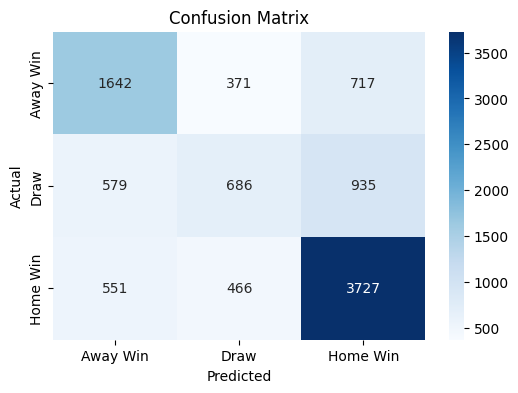

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


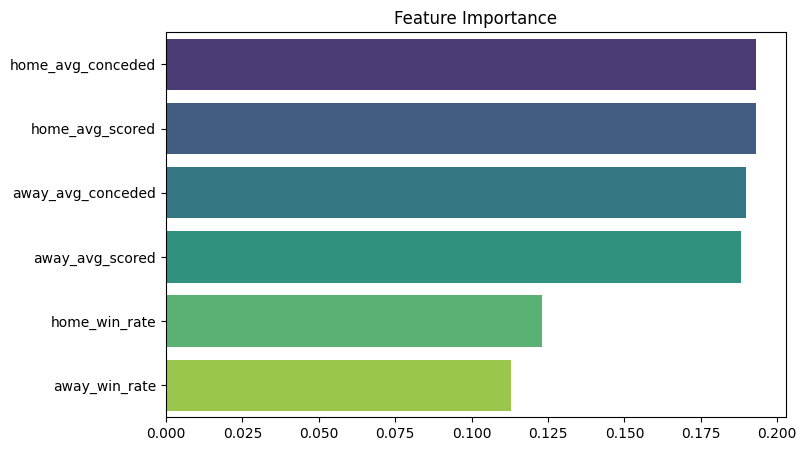

In [12]:
import numpy as np

importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8,5))
sns.barplot(x=importances[indices], y=X.columns[indices], palette="viridis")
plt.title("Feature Importance")
plt.show()


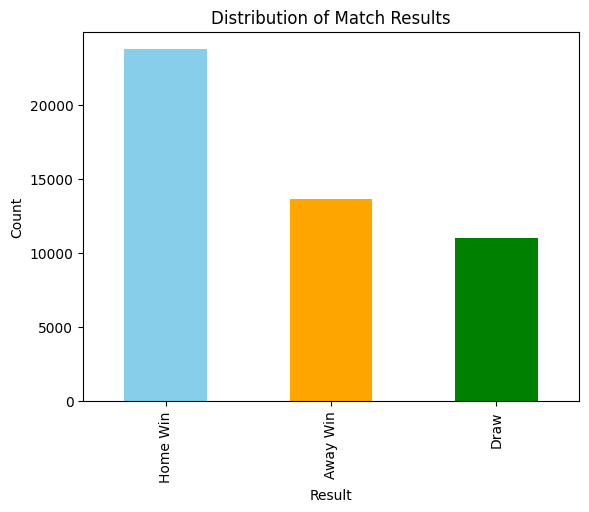

In [13]:
features['result'].value_counts().plot(kind='bar', color=["skyblue","orange","green"])
plt.title("Distribution of Match Results")
plt.xlabel("Result")
plt.ylabel("Count")
plt.show()


In [14]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(class_weight='balanced', n_estimators=200, random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', n_estimators=200,
                       random_state=42)

In [16]:
# Features and Target
X = features[['home_win_rate','home_avg_scored','home_avg_conceded',
              'away_win_rate','away_avg_scored','away_avg_conceded']]
y = features['result']

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [17]:

rf = RandomForestClassifier(
    n_estimators=200,      
    max_depth=None,        
    class_weight="balanced", 
    random_state=42,
    n_jobs=-1             
)


rf.fit(X_train, y_train)


y_pred = rf.predict(X_test)


Accuracy: 0.6246640479636139

Classification Report:
               precision    recall  f1-score   support

    Away Win       0.59      0.59      0.59      2730
        Draw       0.45      0.30      0.36      2200
    Home Win       0.69      0.79      0.74      4744

    accuracy                           0.62      9674
   macro avg       0.58      0.56      0.56      9674
weighted avg       0.61      0.62      0.61      9674



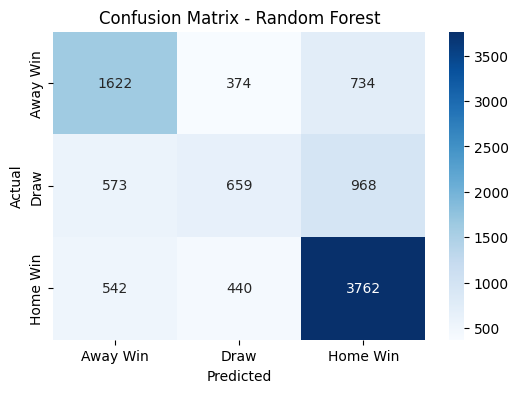

In [18]:
# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=rf.classes_)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=rf.classes_, yticklabels=rf.classes_, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.show()


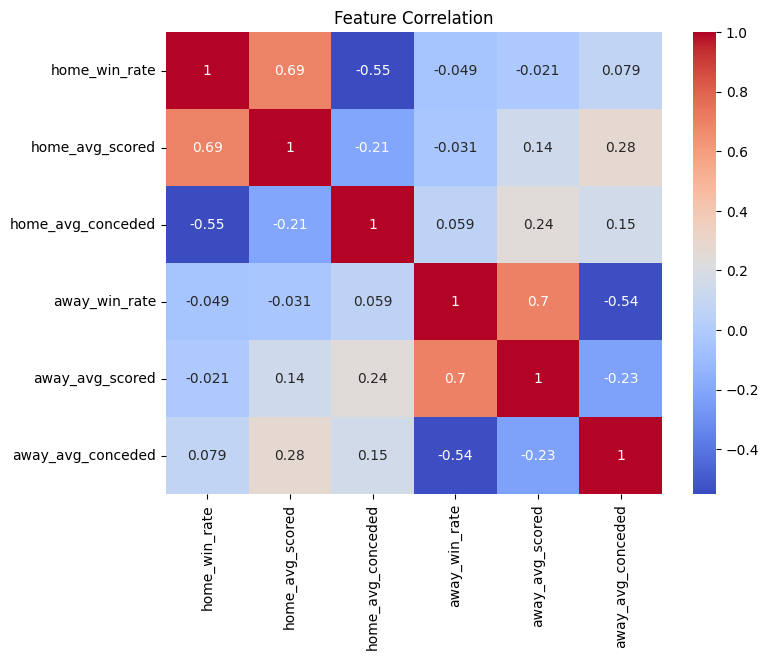

In [19]:

numeric_features = features.select_dtypes(include=['float64','int64'])

# Correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(numeric_features.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation")
plt.show()


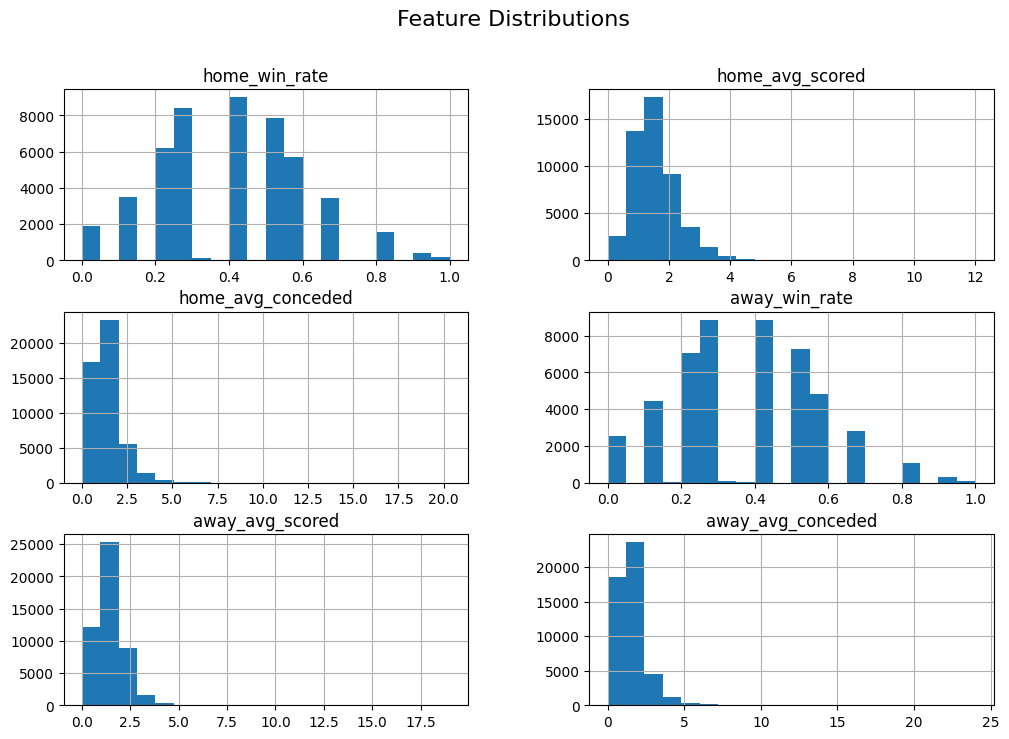

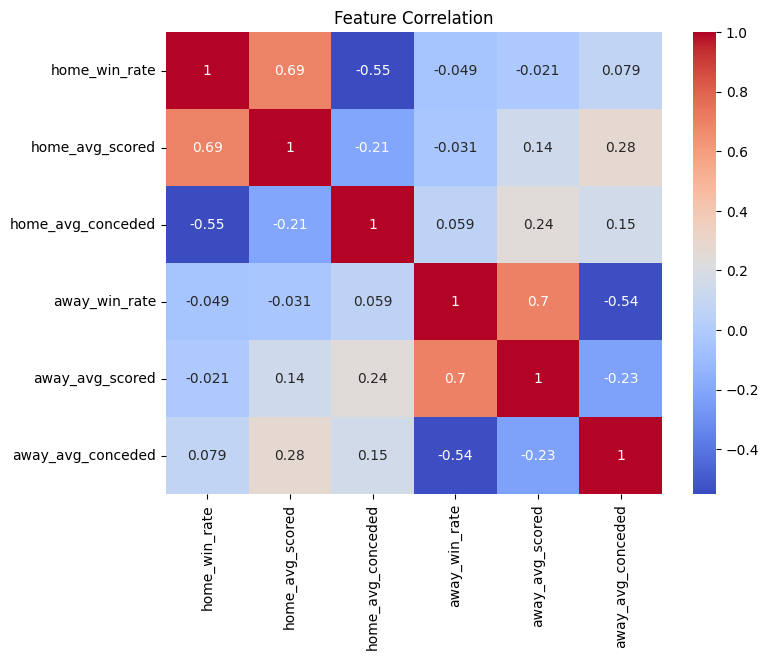

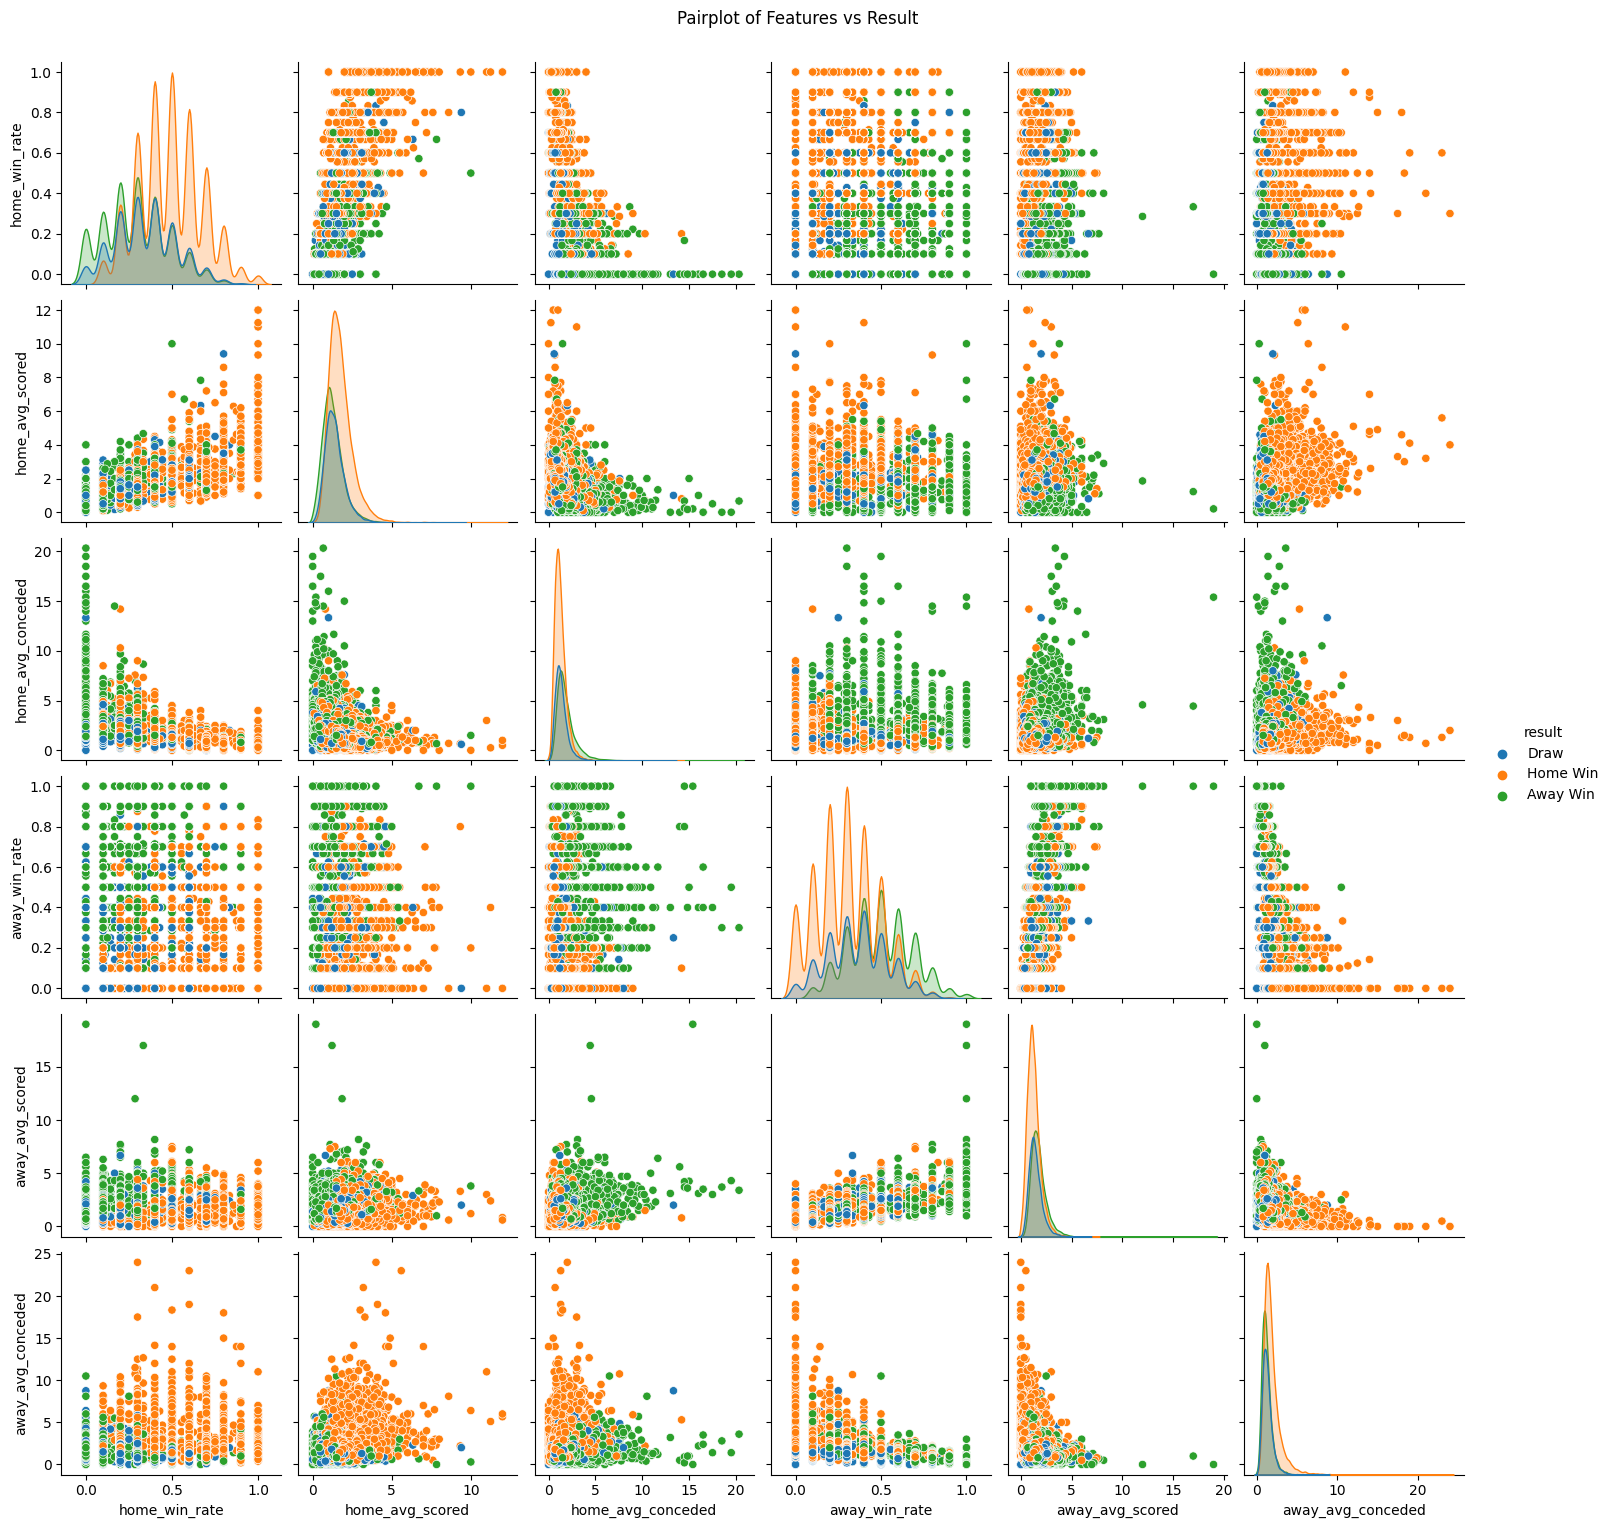

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns


numeric_features = features.select_dtypes(include=['float64','int64'])

# 1️⃣ Distribution plots لكل feature رقمي
numeric_features.hist(figsize=(12,8), bins=20)
plt.suptitle("Feature Distributions", fontsize=16)
plt.show()

# 2️⃣ Correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(numeric_features.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation")
plt.show()

# 3️⃣ Pairplot (مع الـ result كـ hue)
sns.pairplot(features, vars=numeric_features.columns, hue="result", diag_kind="kde")
plt.suptitle("Pairplot of Features vs Result", y=1.02)
plt.show()


In [21]:
print(features.isnull().sum())
print((features == np.inf).sum())
print((features == -np.inf).sum())


home_win_rate        0
home_avg_scored      0
home_avg_conceded    0
away_win_rate        0
away_avg_scored      0
away_avg_conceded    0
result               0
dtype: int64
home_win_rate        0
home_avg_scored      0
home_avg_conceded    0
away_win_rate        0
away_avg_scored      0
away_avg_conceded    0
result               0
dtype: int64
home_win_rate        0
home_avg_scored      0
home_avg_conceded    0
away_win_rate        0
away_avg_scored      0
away_avg_conceded    0
result               0
dtype: int64


In [22]:
#  (Home - Away)
features["win_rate_diff"] = features["home_win_rate"] - features["away_win_rate"]
features["scored_diff"] = features["home_avg_scored"] - features["away_avg_scored"]
features["conceded_diff"] = features["home_avg_conceded"] - features["away_avg_conceded"]


def rolling_features(df, team_col, goals_scored_col, goals_conceded_col, window=5):
    df[team_col+"_form"] = df.groupby(team_col)[goals_scored_col].rolling(window).mean().reset_index(0, drop=True)
    df[team_col+"_defense"] = df.groupby(team_col)[goals_conceded_col].rolling(window).mean().reset_index(0, drop=True)
    return df



In [23]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report

X = features.drop(columns=['result'])
y = features['result']

# Train/Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Gradient Boosting
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)

print("Accuracy (GB):", accuracy_score(y_test, y_pred_gb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_gb))


Accuracy (GB): 0.6532974984494522

Classification Report:
               precision    recall  f1-score   support

    Away Win       0.62      0.64      0.63      2730
        Draw       0.53      0.24      0.33      2200
    Home Win       0.69      0.85      0.76      4744

    accuracy                           0.65      9674
   macro avg       0.61      0.58      0.58      9674
weighted avg       0.63      0.65      0.63      9674



In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

import xgboost as xgb


In [25]:

X = features[['home_win_rate','home_avg_scored','home_avg_conceded',
              'away_win_rate','away_avg_scored','away_avg_conceded']]
y = features['result']

# Encode labels (Draw, Home Win, Away Win → 0,1,2)
le = LabelEncoder()
y = le.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [ ]:
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

grid = GridSearchCV(
    xgb_model,
    param_grid,
    cv=3,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)


Fitting 3 folds for each of 72 candidates, totalling 216 fits


Accuracy: 0.6576390324581352

Classification Report:
               precision    recall  f1-score   support

    Away Win       0.63      0.64      0.63      2730
        Draw       0.55      0.27      0.36      2200
    Home Win       0.69      0.85      0.76      4744

    accuracy                           0.66      9674
   macro avg       0.62      0.59      0.59      9674
weighted avg       0.64      0.66      0.63      9674



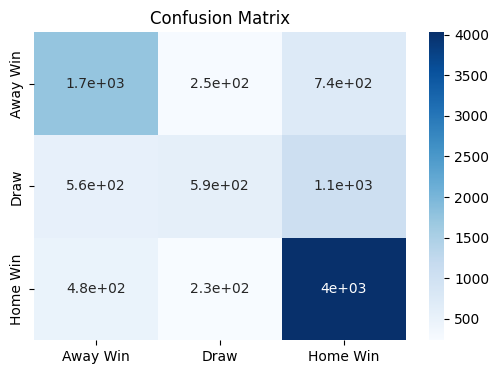

In [27]:
best_model = grid.best_estimator_

y_pred = best_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.show()


<Figure size 800x600 with 0 Axes>

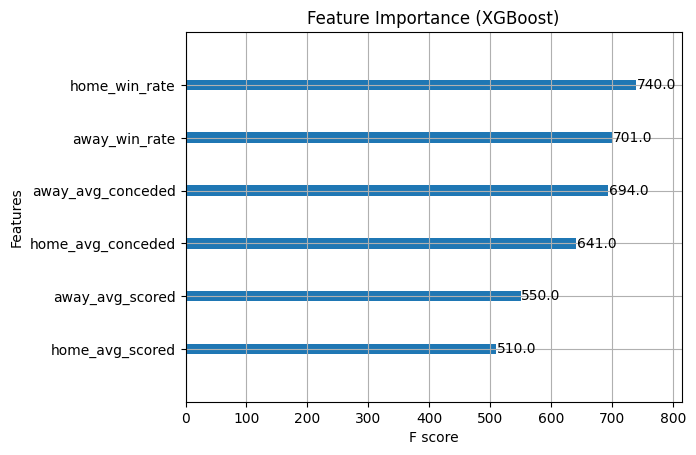

In [28]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

# Feature importance
plt.figure(figsize=(8,6))
plot_importance(best_model, importance_type="weight")
plt.title("Feature Importance (XGBoost)")
plt.show()


In [29]:
# ========================================
# Models Comparison: XGBoost, LightGBM, CatBoost
# ========================================

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report


# train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# XGBoost
xgb_model = XGBClassifier(
    colsample_bytree=0.8, learning_rate=0.1, max_depth=3,
    n_estimators=200, subsample=0.8, random_state=42
)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)

print("XGBoost Accuracy:", accuracy_score(y_test, xgb_preds))
print(classification_report(y_test, xgb_preds))

# LightGBM
lgb_model = LGBMClassifier(
    learning_rate=0.1, max_depth=3, n_estimators=200,
    subsample=0.8, colsample_bytree=0.8, random_state=42
)
lgb_model.fit(X_train, y_train)
lgb_preds = lgb_model.predict(X_test)

print("LightGBM Accuracy:", accuracy_score(y_test, lgb_preds))
print(classification_report(y_test, lgb_preds))

# CatBoost
cat_model = CatBoostClassifier(
    depth=6, learning_rate=0.1, iterations=200, verbose=0, random_state=42
)
cat_model.fit(X_train, y_train)
cat_preds = cat_model.predict(X_test)

print("CatBoost Accuracy:", accuracy_score(y_test, cat_preds))
print(classification_report(y_test, cat_preds))


XGBoost Accuracy: 0.6575356626007857
              precision    recall  f1-score   support

           0       0.63      0.64      0.63      2730
           1       0.54      0.27      0.36      2200
           2       0.69      0.85      0.76      4744

    accuracy                           0.66      9674
   macro avg       0.62      0.59      0.59      9674
weighted avg       0.64      0.66      0.64      9674

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002721 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 627
[LightGBM] [Info] Number of data points in the train set: 38692, number of used features: 6
[LightGBM] [Info] Start training from score -1.265403
[LightGBM] [Info] Start training from score -1.480768
[LightGBM] [Info] Start training from score -0.712511
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


In [31]:
df.columns.tolist()


['date',
 'home_team',
 'away_team',
 'home_score',
 'away_score',
 'tournament',
 'city',
 'country',
 'neutral',
 'result']

In [32]:
import pandas as pd

# نتأكد إن التاريخ مظبوط 
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)

# 
# Home Win / Away Win / Draw
def match_result(row):
    if row['home_score'] > row['away_score']:
        return "Home Win"
    elif row['home_score'] < row['away_score']:
        return "Away Win"
    else:
        return "Draw"

df['result'] = df.apply(match_result, axis=1)


In [33]:

home_stats = df[['date','home_team','home_score','away_score']].copy()
home_stats = home_stats.rename(columns={'home_team':'team','home_score':'scored','away_score':'conceded'})
home_stats['is_home'] = 1

away_stats = df[['date','away_team','away_score','home_score']].copy()
away_stats = away_stats.rename(columns={'away_team':'team','away_score':'scored','home_score':'conceded'})
away_stats['is_home'] = 0

team_matches = pd.concat([home_stats, away_stats]).sort_values('date').reset_index(drop=True)

# rolling averages 
team_matches['avg_scored'] = team_matches.groupby('team')['scored'].transform(lambda x: x.shift().rolling(5, min_periods=1).mean())
team_matches['avg_conceded'] = team_matches.groupby('team')['conceded'].transform(lambda x: x.shift().rolling(5, min_periods=1).mean())
team_matches['win_rate'] = team_matches.groupby('team')['scored'].transform(
    lambda x: (x.shift() > team_matches.loc[x.index, 'conceded'].shift()).rolling(5, min_periods=1).mean()
)


In [34]:
# ناخد آخر إحصائيات قبل كل ماتش
home_features = team_matches[team_matches['is_home']==1].rename(columns={
    'avg_scored':'home_avg_scored',
    'avg_conceded':'home_avg_conceded',
    'win_rate':'home_win_rate'
})[['date','team','home_avg_scored','home_avg_conceded','home_win_rate']]

away_features = team_matches[team_matches['is_home']==0].rename(columns={
    'avg_scored':'away_avg_scored',
    'avg_conceded':'away_avg_conceded',
    'win_rate':'away_win_rate'
})[['date','team','away_avg_scored','away_avg_conceded','away_win_rate']]

features = df.merge(home_features, left_on=['date','home_team'], right_on=['date','team'], how='left') \
             .merge(away_features, left_on=['date','away_team'], right_on=['date','team'], how='left')

# نشيل الأعمدة الزيادة
features = features.drop(columns=['team_x','team_y'])


In [35]:
X = features[['home_win_rate','home_avg_scored','home_avg_conceded',
              'away_win_rate','away_avg_scored','away_avg_conceded']]

y = features['result']


In [36]:
X = features[[
    "home_win_rate","home_avg_scored","home_avg_conceded",
    "away_win_rate","away_avg_scored","away_avg_conceded"
]].copy()

y = features["result"].copy()


In [37]:
X = X.dropna()
y = y.loc[X.index]


In [38]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="mean")
X = imputer.fit_transform(X)


In [39]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.impute import SimpleImputer


X = features[[
    "home_win_rate","home_avg_scored","home_avg_conceded",
    "away_win_rate","away_avg_scored","away_avg_conceded"
]]
y = features["result"]


imputer = SimpleImputer(strategy="mean")
X = imputer.fit_transform(X)

# Train/Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.5279810367927446
              precision    recall  f1-score   support

    Away Win       0.47      0.35      0.40      2737
        Draw       0.00      0.00      0.00      2206
    Home Win       0.54      0.87      0.67      4760

    accuracy                           0.53      9703
   macro avg       0.34      0.41      0.36      9703
weighted avg       0.40      0.53      0.44      9703



In [40]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd


X = features.drop("result", axis=1)
y = features["result"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [41]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight="balanced"),
    "Random Forest": RandomForestClassifier(n_estimators=200, class_weight="balanced", random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42),
    "HistGradientBoosting": HistGradientBoostingClassifier(random_state=42)
}

In [42]:
X_train["date"] = (X_train["date"] - pd.Timestamp("2000-01-01")).dt.days
X_test["date"] = (X_test["date"] - pd.Timestamp("2000-01-01")).dt.days


In [43]:

X = df[['date', 'home_team', 'away_team', 'home_score', 'away_score']]  
y = df['result']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [56]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score


In [49]:
X = df[['date', 'home_team', 'away_team', 'home_score', 'away_score']]  
y = df['result']

In [50]:
X['date'] = pd.to_datetime(X['date'], errors='coerce')
X['year'] = X['date'].dt.year
X['month'] = X['date'].dt.month
X['day'] = X['date'].dt.day
X.drop('date', axis=1, inplace=True)

In [51]:
for col in ['home_team', 'away_team']:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])


In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [53]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [54]:
y_pred = log_reg.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 1.0
              precision    recall  f1-score   support

    Away Win       1.00      1.00      1.00      2769
        Draw       1.00      1.00      1.00      2216
    Home Win       1.00      1.00      1.00      4689

    accuracy                           1.00      9674
   macro avg       1.00      1.00      1.00      9674
weighted avg       1.00      1.00      1.00      9674



In [59]:
df_feat = df.copy()
df_feat['result'] = df_feat.apply(get_result, axis=1)


In [60]:

def get_result(row):
    if row['home_score'] > row['away_score']:
        return 'Home Win'
    elif row['home_score'] < row['away_score']:
        return 'Away Win'
    else:
        return 'Draw'

df_feat['result'] = df_feat.apply(get_result, axis=1)


In [61]:
def encode_result(row, side):
    if row['result'] == 'Home Win':
        return 1 if side == 'home' else 0
    elif row['result'] == 'Away Win':
        return 1 if side == 'away' else 0
    else:  # Draw
        return 0.5

df_feat['home_win_encoded'] = df_feat.apply(lambda row: encode_result(row, 'home'), axis=1)
df_feat['away_win_encoded'] = df_feat.apply(lambda row: encode_result(row, 'away'), axis=1)


In [62]:
df_feat.columns

Index(['date', 'home_team', 'away_team', 'home_score', 'away_score',
       'tournament', 'city', 'country', 'neutral', 'result',
       'home_win_encoded', 'away_win_encoded'],
      dtype='object')

In [63]:
print(df_feat.columns)


Index(['date', 'home_team', 'away_team', 'home_score', 'away_score',
       'tournament', 'city', 'country', 'neutral', 'result',
       'home_win_encoded', 'away_win_encoded'],
      dtype='object')


In [64]:
# Features
X = df_feat[['home_win_encoded', 'away_win_encoded']]
y = df_feat['result']  

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic Regression
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
from sklearn.metrics import classification_report, accuracy_score
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 1.0
              precision    recall  f1-score   support

    Away Win       1.00      1.00      1.00      2769
        Draw       1.00      1.00      1.00      2216
    Home Win       1.00      1.00      1.00      4689

    accuracy                           1.00      9674
   macro avg       1.00      1.00      1.00      9674
weighted avg       1.00      1.00      1.00      9674



In [65]:
print(df.columns)


Index(['date', 'home_team', 'away_team', 'home_score', 'away_score',
       'tournament', 'city', 'country', 'neutral', 'result'],
      dtype='object')


In [66]:

def get_result(row):
    if row['home_score'] > row['away_score']:
        return 'Home Win'
    elif row['home_score'] < row['away_score']:
        return 'Away Win'
    else:
        return 'Draw'

df['result'] = df.apply(get_result, axis=1)


In [67]:
print(df[['home_score', 'away_score', 'result']].head())


   home_score  away_score    result
0           0           0      Draw
1           4           2  Home Win
2           2           1  Home Win
3           2           2      Draw
4           3           0  Home Win


In [68]:
import pandas as pd

def get_result(row):
    if row['home_score'] > row['away_score']:
        return 'Home Win'
    elif row['home_score'] < row['away_score']:
        return 'Away Win'
    else:
        return 'Draw'

df['result'] = df.apply(get_result, axis=1)


print(df[['home_score', 'away_score', 'result']].head())


   home_score  away_score    result
0           0           0      Draw
1           4           2  Home Win
2           2           1  Home Win
3           2           2      Draw
4           3           0  Home Win


In [69]:
# Home Win = 1, Draw = 0.5, Away Win = 0
def encode_result(row, side):
    if row['result'] == 'Home Win':
        return 1 if side == 'home' else 0
    elif row['result'] == 'Away Win':
        return 0 if side == 'home' else 1
    else:
        return 0.5

df['home_win_encoded'] = df.apply(lambda row: encode_result(row, 'home'), axis=1)
df['away_win_encoded'] = df.apply(lambda row: encode_result(row, 'away'), axis=1)


df[['result', 'home_win_encoded', 'away_win_encoded']].head()


,result,home_win_encoded,away_win_encoded
0,Draw,0.5,0.5
1,Home Win,1.0,0.0
2,Home Win,1.0,0.0
3,Draw,0.5,0.5
4,Home Win,1.0,0.0


In [70]:
print(df.columns)


Index(['date', 'home_team', 'away_team', 'home_score', 'away_score',
       'tournament', 'city', 'country', 'neutral', 'result',
       'home_win_encoded', 'away_win_encoded'],
      dtype='object')


In [71]:
def encode_result_with_draw(row):
    if row['home_score'] > row['away_score']:
        return 1  
    elif row['home_score'] < row['away_score']:
        return 0  
    else:
        return 0.5  


df['home_win_encoded'] = df.apply(encode_result_with_draw, axis=1)
df['away_win_encoded'] = 1 - df['home_win_encoded']  


In [72]:
def encode_result_three_columns(row):
    if row['home_score'] > row['away_score']:
        return pd.Series([1, 0, 0])  # home win
    elif row['home_score'] < row['away_score']:
        return pd.Series([0, 0, 1])  # away win
    else:
        return pd.Series([0, 1, 0])  # draw


df[['home_win', 'draw', 'away_win']] = df.apply(encode_result_three_columns, axis=1)


In [73]:
print(df[['home_score', 'away_score', 'home_win', 'draw', 'away_win']].head())


   home_score  away_score  home_win  draw  away_win
0           0           0         0     1         0
1           4           2         1     0         0
2           2           1         1     0         0
3           2           2         0     1         0
4           3           0         1     0         0


In [74]:
print(df.isnull().sum())


date                0
home_team           0
away_team           0
home_score          0
away_score          0
tournament          0
city                0
country             0
neutral             0
result              0
home_win_encoded    0
away_win_encoded    0
home_win            0
draw                0
away_win            0
dtype: int64


In [87]:
# One-Hot Encoding
df_encoded = pd.get_dummies(df, columns=['home_team', 'away_team', 'tournament', 'city', 'country'])


In [88]:
from sklearn.model_selection import train_test_split

X = df_encoded.drop(['home_win', 'draw', 'away_win', 'home_score', 'away_score'], axis=1)
y = df_encoded[['home_win', 'draw', 'away_win']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [89]:
X = df_encoded.drop(['home_win', 'draw', 'away_win', 'home_score', 'away_score', 'date'], axis=1)


In [90]:
df['year'] = pd.to_datetime(df['date']).dt.year
df['month'] = pd.to_datetime(df['date']).dt.month
df['day'] = pd.to_datetime(df['date']).dt.day


In [91]:
df_encoded = pd.get_dummies(df, columns=['home_team', 'away_team', 'tournament', 'city', 'country'])


In [92]:
X = df_encoded.drop(['home_win', 'draw', 'away_win', 'home_score', 'away_score', 'date'], axis=1)
y = df_encoded[['home_win', 'draw', 'away_win']]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [93]:
# Encode match results into three columns: home_win, draw, away_win
def encode_result_three_columns(row):
    if row['home_score'] > row['away_score']:
        return pd.Series([1, 0, 0])  # home win
    elif row['home_score'] < row['away_score']:
        return pd.Series([0, 0, 1])  # away win
    else:
        return pd.Series([0, 1, 0])  # draw

df[['home_win', 'draw', 'away_win']] = df.apply(encode_result_three_columns, axis=1)


In [94]:
# Convert date column to numeric features (year, month, day)
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day


In [95]:
# Convert categorical columns into numeric columns using one-hot encoding
categorical_cols = ['home_team', 'away_team', 'tournament', 'city', 'country']
df_encoded = pd.get_dummies(df, columns=categorical_cols)


In [96]:
# Drop unnecessary columns from features
X = df_encoded.drop(['home_win', 'draw', 'away_win', 'home_score', 'away_score', 'date'], axis=1)

# Target columns
y = df_encoded[['home_win', 'draw', 'away_win']]

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [97]:
# Encode results as label (0=home_win, 1=draw, 2=away_win)
def encode_result_label(row):
    if row['home_score'] > row['away_score']:
        return 0
    elif row['home_score'] < row['away_score']:
        return 2
    else:
        return 1

df['result_label'] = df.apply(encode_result_label, axis=1)


In [98]:
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day


In [99]:
categorical_cols = ['home_team', 'away_team', 'tournament', 'city', 'country']
df_encoded = pd.get_dummies(df, columns=categorical_cols)


In [100]:
# Keep only pre-match features (exclude scores)
X = df_encoded.drop(['home_score', 'away_score', 'result_label', 'date'], axis=1)
y = df_encoded['result_label']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [101]:
!pip install xgboost


In [105]:
from xgboost import XGBClassifier


In [107]:
# معالجة عمود التاريخ
X['year'] = X['date'].dt.year
X['month'] = X['date'].dt.month
X['day'] = X['date'].dt.day

# نشيل عمود التاريخ الأصلي
X = X.drop(columns=['date'])

# نكمل بنفس الخطوات
for col in X.select_dtypes(include=['object']).columns:
    X[col] = LabelEncoder().fit_transform(X[col])

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# تدريب XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train, y_train)

# التقييم
y_pred = xgb_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2769
           1       1.00      1.00      1.00      2216
           2       1.00      1.00      1.00      4689

    accuracy                           1.00      9674
   macro avg       1.00      1.00      1.00      9674
weighted avg       1.00      1.00      1.00      9674



In [110]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

# معالجة عمود التاريخ
X['year'] = X['date'].dt.year
X['month'] = X['date'].dt.month
X['day'] = X['date'].dt.day
X = X.drop(columns=['date'])

# تحويل النصوص لأرقام
for col in X.select_dtypes(include=['object']).columns:
    X[col] = LabelEncoder().fit_transform(X[col])

# تقسيم البيانات
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# تدريب الموديل
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train, y_train)

# التقييم
y_pred = xgb_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2769
           1       1.00      1.00      1.00      2216
           2       1.00      1.00      1.00      4689

    accuracy                           1.00      9674
   macro avg       1.00      1.00      1.00      9674
weighted avg       1.00      1.00      1.00      9674



In [111]:
y_pred = xgb_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2769
           1       1.00      1.00      1.00      2216
           2       1.00      1.00      1.00      4689

    accuracy                           1.00      9674
   macro avg       1.00      1.00      1.00      9674
weighted avg       1.00      1.00      1.00      9674



Here is the overfitting

In [112]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(xgb_model, X, y, cv=5)
print("CV mean accuracy:", scores.mean())


CV mean accuracy: 1.0


In [115]:
X = df_encoded.drop(['home_score', 'away_score', 'result_label', 'date'], axis=1)


So, we need to remove some features

In [116]:
# Encode results as label (0=home_win, 1=draw, 2=away_win)
def encode_result_label(row):
    if row['home_score'] > row['away_score']:
        return 0
    elif row['home_score'] < row['away_score']:
        return 2
    else:
        return 1

df['result_label'] = df.apply(encode_result_label, axis=1)


In [117]:
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day


In [118]:
# Keep only pre-match features (exclude scores)
pre_match_cols = ['home_team', 'away_team', 'tournament', 'city', 'country', 'year', 'month', 'day']

df_features = df[pre_match_cols]
df_target = df['result_label']


In [120]:
# اختار أفضل 10 فرق Home
top_home_teams = df['home_team'].value_counts().head(10).index.tolist()

# اختار أفضل 10 فرق Away
top_away_teams = df['away_team'].value_counts().head(10).index.tolist()

# بعدين طبق الفلترة
df_features = df[pre_match_cols].copy()
df_features['home_team'] = df_features['home_team'].apply(lambda x: x if x in top_home_teams else 'Other')
df_features['away_team'] = df_features['away_team'].apply(lambda x: x if x in top_away_teams else 'Other')


In [122]:
categorical_cols = ['home_team', 'away_team', 'tournament', 'city', 'country']
df_encoded = pd.get_dummies(df_features, columns=categorical_cols)
X = df_encoded
y = df_target


In [123]:
xgb_model = XGBClassifier(
    objective='multi:softmax',
    num_class=3,
    max_depth=4,           
    learning_rate=0.1,
    n_estimators=200,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='mlogloss'
)

# Cross-validation
scores = cross_val_score(xgb_model, X, y, cv=5)
print("CV mean accuracy:", scores.mean())

# Train final model
xgb_model.fit(X, y)


CV mean accuracy: 0.30945168964352865


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_class=3, num_parallel_tree=None, ...)

✅ after Encoding: tournament                 int64
city                       int64
country                    int64
year                       int32
month                      int32
day                        int32
home_team_Brazil            bool
home_team_England           bool
home_team_France            bool
home_team_Germany           bool
home_team_Hungary           bool
home_team_Mexico            bool
home_team_Other             bool
home_team_South Korea       bool
home_team_Sweden            bool
home_team_United States     bool
away_team_England           bool
away_team_Germany           bool
away_team_Hungary           bool
away_team_Other             bool
away_team_Paraguay          bool
away_team_Poland            bool
away_team_South Korea       bool
away_team_Sweden            bool
away_team_Uruguay           bool
away_team_Zambia            bool
dtype: object


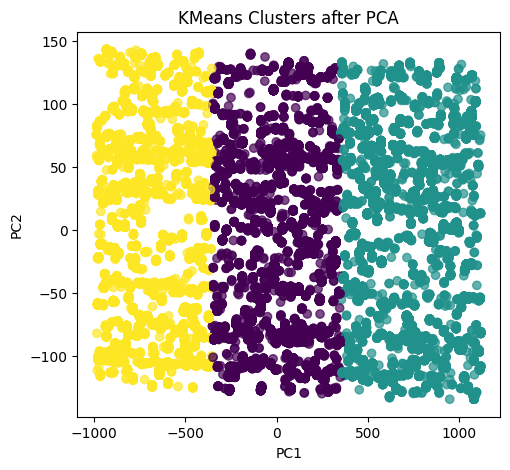

In [130]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


df_exp = df_encoded.copy()


if "result" in df_exp.columns:
    y = df_exp["result"]
    X = df_exp.drop("result", axis=1)
else:
    y = None
    X = df_exp

# Label Encodig
for col in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

print("✅ after Encoding:", X.dtypes)

# PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

# KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_pca)

#clusters
plt.figure(figsize=(12,5))

# 1. Cluster labels
plt.subplot(1,2,1)
plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters, cmap='viridis', alpha=0.7)
plt.title("KMeans Clusters after PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")

# 2. Ground truth labels 
if y is not None:
    le_y = LabelEncoder()
    y_encoded = le_y.fit_transform(y.astype(str))
    plt.subplot(1,2,2)
    plt.scatter(X_pca[:,0], X_pca[:,1], c=y_encoded, cmap='coolwarm', alpha=0.7)
    plt.title("Ground Truth: Result")
    plt.xlabel("PC1")
    plt.ylabel("PC2")

plt.show()


In [139]:
print(df_cluster.columns)


Index(['home_team', 'away_team', 'home_score', 'away_score', 'tournament',
       'city', 'country', 'neutral', 'result', 'home_win_encoded',
       'away_win_encoded', 'home_win', 'draw', 'away_win', 'year', 'month',
       'day', 'result_encoded', 'result_label'],
      dtype='object')


In [140]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# X = كل الأعمدة اللي هتستخدمها في الكلسترينج (من غير الأعمدة اللي بتدي النتيجة)
features = ['home_score', 'away_score', 'tournament', 'city', 'country',
            'neutral', 'year', 'month', 'day']

X = df_cluster[features]

# 1. Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. PCA لتقليل الأبعاد
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# 3. KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_pca)

df_cluster['cluster'] = clusters
print(df_cluster[['home_team','away_team','cluster']].head())


   home_team  away_team  cluster
0        247         87        2
1         86        241        2
2        247         87        2
3         86        241        2
4        247         87        2


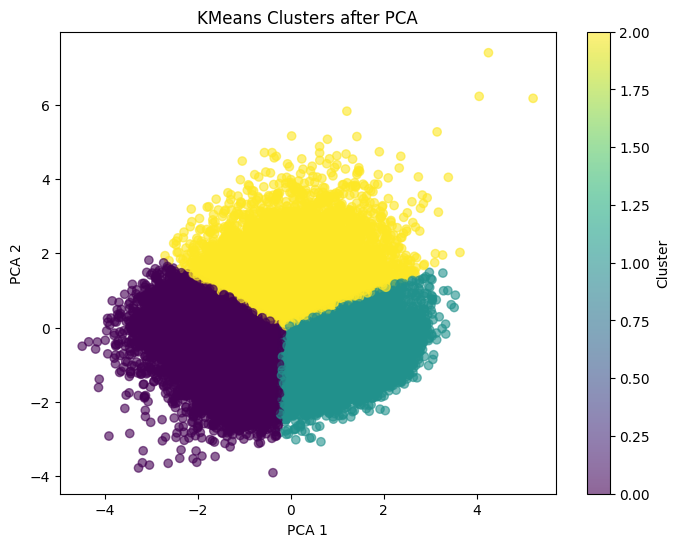

In [141]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', alpha=0.6)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("KMeans Clusters after PCA")
plt.colorbar(label="Cluster")
plt.show()


In [142]:
from sklearn.metrics import silhouette_score

score = silhouette_score(X_pca, clusters)
print("Silhouette Score:", score)


Silhouette Score: 0.3712500555868463
